In [3]:
import pandas as pd
import numpy as np
import jenkspy
import matplotlib.pyplot as plt
from scipy import stats, optimize
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------------------------------------------
# 1. 数据预处理（严格匹配C题.pdf附录1数据格式）
# ------------------------------------------------------------------------------
def preprocess_nipt_data(file_path, sheet_name="数据"):
    """
    功能：按C题要求筛选男胎样本、处理关键指标，排除无效数据
    输入：Excel文件路径（含C题附件数据）
    输出：预处理后的男胎检测DataFrame
    """
    # 读取数据（按附录1列名匹配，若实际列名不同需对应修改）
    df = pd.read_excel("nipt_data.xlsx")
    
    # 1.1 筛选男胎样本（Y染色体浓度V列非空白，参考{insert\_element\_0\_}）
    df = df[df["Y染色体浓度（V列）"].notna()].copy()
    
    # 1.2 处理孕周：将"周数+天数"转为小数（如12周3天→12.43周，参考{insert\_element\_1\_}）
    def convert_gestational_week(week_str):
        if pd.isna(week_str) or "+" not in str(week_str):
            return np.nan
        week_part, day_part = str(week_str).split("+")
        week = int(week_part.strip())
        day = int(day_part.strip())
        return round(week + day / 7, 2)
    
    df["孕周_小数"] = df["检测孕周（J列）"].apply(convert_gestational_week)
    
    # 1.3 筛选有效孕周（10~25周，参考{insert\_element\_2\_}）
    df = df[(df["孕周_小数"] >= 10) & (df["孕周_小数"] <= 25)].copy()
    
    # 1.4 排除测序质量异常样本（GC含量40%~60%，参考{insert\_element\_3\_}）
    df = df[(df["GC含量（P列）"] >= 40) & (df["GC含量（P列）"] <= 60)].copy()
    
    # 1.5 保留关键字段（BMI、孕周、Y染色体浓度、孕妇代码，参考{insert\_element\_4\_}）
    key_cols = [
        "孕妇代码（B列）", "孕妇BMI（K列）", "孕周_小数", 
        "Y染色体浓度（V列）", "检测抽血次数（I列）"
    ]
    df = df[key_cols].dropna().reset_index(drop=True)
    
    # 1.6 计算每个孕妇的"达标状态"（浓度≥4%为达标，参考{insert\_element\_5\_}）
    df["达标状态"] = (df["Y染色体浓度（V列）"] >= 4).astype(int)
    
    # 输出预处理结果
    print(f"预处理完成：有效男胎样本数={len(df)}")
    print(f"BMI范围：{df['孕妇BMI（K列）'].min():.2f} ~ {df['孕妇BMI（K列）'].max():.2f}")
    print(f"孕周范围：{df['孕周_小数'].min():.2f} ~ {df['孕周_小数'].max():.2f}")
    return df


In [4]:

# ------------------------------------------------------------------------------
# 2. Jenks自然断点BMI分组（参考{insert\_element\_6\_}经验分组逻辑）
# ------------------------------------------------------------------------------
def jenks_bmi_grouping(df, n_classes=4):
    """
    功能：用Jenks法对BMI分组，最小化组内差异、最大化组间差异
    输入：预处理数据、目标分组数
    输出：含分组标签的数据、分组统计、分组断点
    """
    # 提取BMI数据（去重避免重复计算）
    bmi_data = df["孕妇BMI（K列）"].drop_duplicates().sort_values()
    
    # 执行Jenks分组
    breaks = jenkspy.jenks_breaks(bmi_data.values, n_classes)
    df["BMI分组"] = pd.cut(
        df["孕妇BMI（K列）"], 
        bins=breaks, 
        include_lowest=True,
        labels=[f"BMI组{i+1}（{breaks[i]:.1f}-{breaks[i+1]:.1f}）" for i in range(n_classes)]
    )
    
    # 计算每组统计信息
    group_stats = df.groupby("BMI分组").agg({
        "孕妇代码（B列）": "nunique",  # 孕妇人数
        "Y染色体浓度（V列）": ["mean", "std"],  # 浓度均值/标准差
        "达标状态": "mean",  # 达标率
        "孕周_小数": ["min", "max"]  # 孕周范围
    }).round(3)
    
    # 重命名统计列
    group_stats.columns = ["孕妇人数", "浓度均值(%)", "浓度标准差", "达标率", "最小孕周", "最大孕周"]
    group_stats["达标率"] = (group_stats["达标率"] * 100).round(1).astype(str) + "%"
    
    # 输出分组结果
    print("\n" + "="*60)
    print("Jenks BMI分组结果：")
    print(f"分组断点：{[round(b,1) for b in breaks]}")
    print("\n分组统计：")
    print(group_stats)
    return df, group_stats, breaks


In [ ]:

# ------------------------------------------------------------------------------
# 3. 计算每组最佳NIPT时点（基于风险最小化，参考{insert\_element\_7\_}风险规则）
# ------------------------------------------------------------------------------
def calculate_optimal_time(df):
    """
    功能：对每组BMI，找到"达标率高且风险低"的最佳检测时点
    风险规则：12周内（低风险，风险值=0）、13-27周（高风险，风险值=孕周-12）、28周后
    """
    # 定义风险函数
    def risk_function(gestational_week):
        if gestational_week <= 12:
            return 0  # 早期：低风险
        elif 13 <= gestational_week <= 27:
            return gestational_week - 12  # 中期：风险随孕周线性增加
        else:
            return 2 * (gestational_week - 27) + 15  # 晚期：极高风险（放大系数2）
    
    # 按BMI分组计算最佳时点
    optimal_results = []
    for group in df["BMI分组"].unique():
        group_data = df[df["BMI分组"] == group].copy()
        
        # 1. 按孕周分段，计算每段的平均达标率
        week_bins = np.arange(10, 26, 0.5)  # 0.5周为步长
        group_data["孕周分段"] = pd.cut(group_data["孕周_小数"], bins=week_bins, include_lowest=True)
        week_stats = group_data.groupby("孕周分段").agg({
            "达标状态": "mean",  # 该孕周段达标率
            "孕周_小数": "mean"  # 该孕周段平均孕周
        }).reset_index()
        week_stats.columns = ["孕周分段", "达标率", "平均孕周"]
        week_stats = week_stats[week_stats["达标率"] >= 0.8]  # 过滤达标率<80%的时点（保证准确性）
        
        if len(week_stats) == 0:
            # 若无高达标率时点，取达标率最高的时点
            week_stats = group_data.groupby("孕周分段").agg({
                "达标状态": "mean",
                "孕周_小数": "mean"
            }).reset_index().nlargest(1, "达标状态")
        
        # 2. 计算每个候选时点的风险值
        week_stats["风险值"] = week_stats["平均孕周"].apply(risk_function)
        
        # 3. 选择风险最小的时点作为最佳时点
        optimal_row = week_stats.nsmallest(1, "风险值").iloc[0]
        optimal_results.append({
            "BMI分组": group,
            "最佳检测时点（周）": round(optimal_row["平均孕周"], 2),
            "对应达标率": round(optimal_row["达标率"] * 100, 1),
            "对应风险值": round(optimal_row["风险值"], 2)
        })
    
    # 转为DataFrame并输出
    optimal_df = pd.DataFrame(optimal_results)
    print("\n" + "="*60)
    print("各BMI组最佳NIPT时点：")
    print(optimal_df.to_string(index=False))
    return optimal_df


In [5]:

# ------------------------------------------------------------------------------
# 4. 检测误差分析（参考{insert\_element\_9\_}误差影响要求）
# ------------------------------------------------------------------------------
def analyze_detection_error(df, optimal_df, error_rate=0.1):
    """
    功能：模拟检测误差（浓度测量误差），分析对最佳时点的影响
    输入：原始数据、最佳时点结果、误差率（默认10%）
    输出：误差分析结果
    """
    # 模拟误差：为Y染色体浓度添加±10%的随机误差
    df_error = df.copy()
    np.random.seed(42)  # 固定随机种子保证可复现
    error = df_error["Y染色体浓度（V列）"] * error_rate * (2 * np.random.rand(len(df_error)) - 1)
    df_error["Y染色体浓度（含误差）"] = df_error["Y染色体浓度（V列）"] + error
    df_error["达标状态（含误差）"] = (df_error["Y染色体浓度（含误差）"] >= 4).astype(int)
    
    # 重新计算每组最佳时点（含误差）
    error_optimal_results = []
    for group in df_error["BMI分组"].unique():
        group_data = df_error[df_error["BMI分组"] == group].copy()
        group_data["孕周分段"] = pd.cut(group_data["孕周_小数"], bins=np.arange(10,26,0.5), include_lowest=True)
        
        week_stats = group_data.groupby("孕周分段").agg({
            "达标状态（含误差）": "mean",
            "孕周_小数": "mean"
        }).reset_index()
        week_stats.columns = ["孕周分段", "达标率（含误差）", "平均孕周"]
        week_stats = week_stats[week_stats["达标率（含误差）"] >= 0.7]  # 误差后放宽达标率要求
        
        if len(week_stats) == 0:
            week_stats = group_data.groupby("孕周分段").agg({
                "达标状态（含误差）": "mean",
                "孕周_小数": "mean"
            }).reset_index().nlargest(1, "达标状态（含误差）")
        
        # 计算风险值并选最佳时点
        week_stats["风险值（含误差）"] = week_stats["平均孕周"].apply(
            lambda x: 0 if x<=12 else (x-12) if 13<=x<=27 else 2*(x-27)+15
        )
        optimal_row = week_stats.nsmallest(1, "风险值（含误差）").iloc[0]
        
        # 匹配原始最佳时点，计算差异
        original_optimal = optimal_df[optimal_df["BMI分组"] == group]["最佳检测时点（周）"].iloc[0]
        error_optimal_results.append({
            "BMI分组": group,
            "原始最佳时点（周）": original_optimal,
            "误差后最佳时点（周）": round(optimal_row["平均孕周"], 2),
            "时点差异（天）": round((optimal_row["平均孕周"] - original_optimal) * 7, 1),
            "误差后达标率": round(optimal_row["达标率（含误差）"] * 100, 1)
        })
    
    # 输出误差分析结果
    error_df = pd.DataFrame(error_optimal_results)
    print("\n" + "="*60)
    print(f"检测误差分析（浓度±{error_rate*100}%误差）：")
    print(error_df.to_string(index=False))
    return error_df


In [6]:

# ------------------------------------------------------------------------------
# 5. 结果可视化（分组、时点、误差对比图）
# ------------------------------------------------------------------------------
def visualize_results(df, group_stats, optimal_df, error_df):
    """功能：生成分组浓度分布、最佳时点对比、误差影响可视化图"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 图1：各BMI组Y染色体浓度箱线图
    bmi_groups = df["BMI分组"].unique()
    concentrations = [df[df["BMI分组"] == g]["Y染色体浓度（V列）"].values for g in bmi_groups]
    axes[0,0].boxplot(concentrations, labels=[g.split("（")[0] for g in bmi_groups])
    axes[0,0].axhline(y=4, color="red", linestyle="--", label="达标阈值（4%）")
    axes[0,0].set_title("各BMI组Y染色体浓度分布", fontsize=12, fontweight="bold")
    axes[0,0].set_ylabel("Y染色体浓度（%）")
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)
    
    # 图2：各BMI组最佳时点与达标率
    groups_short = [g.split("（")[0] for g in optimal_df["BMI分组"]]
    x = np.arange(len(groups_short))
    width = 0.35
    bars1 = axes[0,1].bar(x - width/2, optimal_df["最佳检测时点（周）"], width, label="最佳时点（周）")
    axes2 = axes[0,1].twinx()
    bars2 = axes2.bar(x + width/2, optimal_df["对应达标率"], width, color="orange", label="达标率（%）")
    axes[0,1].set_title("各BMI组最佳时点与达标率", fontsize=12, fontweight="bold")
    axes[0,1].set_xlabel("BMI分组")
    axes[0,1].set_ylabel("最佳检测时点（周）", color="blue")
    axes2.set_ylabel("达标率（%）", color="orange")
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(groups_short, rotation=45)
    axes[0,1].grid(alpha=0.3)
    
    # 图3：误差前后最佳时点对比
    x = np.arange(len(groups_short))
    axes[1,0].bar(x - width/2, error_df["原始最佳时点（周）"], width, label="原始最佳时点")
    axes[1,0].bar(x + width/2, error_df["误差后最佳时点（周）"], width, label="误差后最佳时点")
    axes[1,0].set_title("检测误差对最佳时点的影响", fontsize=12, fontweight="bold")
    axes[1,0].set_xlabel("BMI分组")
    axes[1,0].set_ylabel("最佳检测时点（周）")
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(groups_short, rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)
    
    # 图4：各BMI组孕妇人数与达标率
    group_counts = group_stats["孕妇人数"].values
    group_rates = [float(r.strip("%")) for r in group_stats["达标率"].values]
    axes[1,1].bar(groups_short, group_counts, color="green", alpha=0.7, label="孕妇人数")
    axes2 = axes[1,1].twinx()
    axes2.plot(groups_short, group_rates, color="red", marker="o", label="达标率（%）")
    axes[1,1].set_title("各BMI组孕妇人数与达标率", fontsize=12, fontweight="bold")
    axes[1,1].set_xlabel("BMI分组")
    axes[1,1].set_ylabel("孕妇人数", color="green")
    axes2.set_ylabel("达标率（%）", color="red")
    axes[1,1].tick_params(axis="x", rotation=45)
    axes[1,1].legend(loc="upper left")
    axes2.legend(loc="upper right")

In [11]:
import pandas as pd
import numpy as np
import jenkspy
import matplotlib.pyplot as plt
from scipy import stats
import warnings
# 保留警告提示（便于定位错误，不再屏蔽）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------------------------------------------
# 1. 数据预处理（含中间输出，定位样本流失环节）
# ------------------------------------------------------------------------------
def preprocess_nipt_data(file_path, sheet_name="数据"):
    print("="*50)
    print("【步骤1：开始数据读取】")
    try:
        df = pd.read_excel("nipt_data.xlsx")
        print(f"✅ 成功读取文件：{file_path}，总样本数={len(df)}")
        print(f"✅ 读取到的列名：{list(df.columns)}")
    except Exception as e:
        print(f"❌ 数据读取失败！原因：{str(e)}")
        return None
    
    print("\n【步骤2：验证数据格式（前2行样本）】")
    print(df.head(2).to_string())
    
    # 【修改1：Y染色体浓度列匹配】直接用实际列名"Y染色体浓度"
    print("\n【步骤3：筛选男胎样本（Y染色体浓度非空）】")
    y_col = "Y染色体浓度"  # 与Excel列名完全一致
    if y_col not in df.columns:
        print(f"❌ 未找到Y染色体浓度列！当前列名仅包含：{list(df.columns)}")
        return None
    
    df_male = df[df[y_col].notna()].copy()
    print(f"✅ 筛选前总样本数={len(df)}，筛选后男胎样本数={len(df_male)}")
    if len(df_male) == 0:
        print("❌ 无有效男胎样本！请检查Y染色体浓度列数据是否为空")
        return None
    
    # 【修改2：孕周列匹配】用实际列名"检测孕周"
    print("\n【步骤4：处理孕周（转为小数格式）】")
    week_col = "检测孕周"  # 与Excel列名"检测孕周"一致
    if week_col not in df_male.columns:
        print(f"❌ 未找到孕周列！当前列名仅包含：{list(df_male.columns)}")
        return None
    
    def convert_week(week_str):
        if pd.isna(week_str) or "+" not in str(week_str):
            return np.nan
        try:
            week_part, day_part = str(week_str).split("+")
            return round(int(week_part.replace("w", "")) + int(day_part)/7, 2)
        except:
            return np.nan
    
    df_male["孕周_小数"] = df_male[week_col].apply(convert_week)
    df_week_valid = df_male[(df_male["孕周_小数"] >= 10) & (df_male["孕周_小数"] <= 25)].copy()
    print(f"✅ 孕周处理前样本数={len(df_male)}，有效孕周（10-25周）样本数={len(df_week_valid)}")
    if len(df_week_valid) == 0:
        print("❌ 无有效孕周样本！请检查孕周列格式（需为'Xw+Y'，如11w+6）")
        return None
    
        # 【步骤5：筛选正常GC含量样本】（修改后）
    print("\n【步骤5：筛选正常GC含量样本】")
    gc_col = "GC含量"  # 已匹配Excel实际列名
    if gc_col not in df_week_valid.columns:
        print(f"❌ 未找到GC含量列！当前列名仅包含：{list(df_week_valid.columns)}")
        return None
    
    # 关键修改：按小数0.4-0.6筛选（对应40%-60%，符合C题.pdf附录1要求）
    df_gc_valid = df_week_valid[(df_week_valid[gc_col] >= 0.4) & (df_week_valid[gc_col] <= 0.6)].copy()
    print(f"✅ GC处理前样本数={len(df_week_valid)}，正常GC（0.4-0.6，即40%-60%）样本数={len(df_gc_valid)}")
    if len(df_gc_valid) == 0:
        # 若仍为0，可适当放宽范围（如0.38-0.62），需结合实际数据分布
        df_gc_valid = df_week_valid[(df_week_valid[gc_col] >= 0.38) & (df_week_valid[gc_col] <= 0.62)].copy()
        print(f"⚠️  严格筛选后样本为0，已放宽范围至0.38-0.62，当前样本数={len(df_gc_valid)}")
        if len(df_gc_valid) == 0:
            print("❌ 放宽范围后仍无正常GC样本！请检查GC含量列数据分布")
            return None
    
    # 【修改4：BMI列匹配】用实际列名"孕妇BMI"
    print("\n【步骤6：保留核心分析列】")
    bmi_col = "孕妇BMI"  # 与Excel列名"孕妇BMI"一致
    core_cols = [
        "孕妇代码",  # 匹配Excel实际列名"孕妇代码"
        bmi_col,
        "孕周_小数",
        y_col,
        gc_col
    ]
    core_cols = list(dict.fromkeys([col for col in core_cols if col in df_gc_valid.columns]))
    df_final = df_gc_valid[core_cols].dropna().reset_index(drop=True)
    
    print(f"✅ 最终预处理完成！有效样本数={len(df_final)}")
    print(f"✅ 核心列数据范围：")
    print(f"  - BMI：{df_final[bmi_col].min():.2f} ~ {df_final[bmi_col].max():.2f}")
    print(f"  - 孕周：{df_final['孕周_小数'].min():.2f} ~ {df_final['孕周_小数'].max():.2f}")
    print(f"  - Y浓度：{df_final[y_col].min():.2f}% ~ {df_final[y_col].max():.2f}%")
    print("="*50)
    return df_final, bmi_col, y_col

# ------------------------------------------------------------------------------
# 2. Jenks BMI分组（含中间输出，定位分组异常）
# ------------------------------------------------------------------------------
def jenks_bmi_grouping(df, bmi_col, n_classes=4):
    print("\n【步骤7：开始Jenks BMI分组】")
    # 提取BMI数据（去重避免重复计算）
    bmi_data = df[bmi_col].drop_duplicates().sort_values()
    print(f"✅ BMI数据范围：{bmi_data.min():.2f} ~ {bmi_data.max():.2f}，去重后数据量={len(bmi_data)}")
    
    # 执行Jenks分组（捕获分组失败错误）
    try:
        breaks = jenkspy.jenks_breaks(bmi_data.values, n_classes)
        print(f"✅ Jenks分组成功！分组断点：{[round(b,2) for b in breaks]}")
    except Exception as e:
        print(f"❌ Jenks分组失败！原因：{str(e)}（可能是数据量不足，需至少{n_classes+1}个去重值）")
        return None, None
    
    # 为样本添加分组标签
    df["BMI分组"] = pd.cut(
        df[bmi_col], 
        bins=breaks, 
        include_lowest=True,
        labels=[f"BMI组{i+1}（{breaks[i]:.1f}-{breaks[i+1]:.1f}）" for i in range(n_classes)]
    )
    
    # 输出分组统计（验证分组有效性）
    group_stats = df.groupby("BMI分组").agg({
        bmi_col: ["mean", "count"],
        y_col: lambda x: (x.mean() * 100).round(2)  # 关键：*100→百分比
    }).round(2)
    group_stats.columns = ["BMI均值", "样本数", "Y浓度均值(%)"]
    
    print("\n【步骤8：BMI分组统计结果】")
    print(group_stats.to_string())
    # 检查分组是否均衡（避免某组样本数为0）
    zero_groups = group_stats[group_stats["样本数"] == 0].index.tolist()
    if zero_groups:
        print(f"⚠️  警告：以下分组无样本！{zero_groups}，建议减少分组数（如n_classes=3）")
    return df, group_stats, breaks

# ------------------------------------------------------------------------------
# 3. 计算最佳NIPT时点（含中间输出，定位时点计算异常）
# ------------------------------------------------------------------------------
def calculate_optimal_time(df, bmi_col, y_col):
    print("\n【步骤9：开始计算最佳NIPT时点】")
    # 定义风险函数（C题.pdf：12周内低风险，13-27周高风险）
    def risk_func(week):
        return 0 if week <= 12 else (week - 12)
    
    optimal_results = []
    # 按BMI分组计算
    for group in df["BMI分组"].unique():
        group_data = df[df["BMI分组"] == group].copy()
        print(f"\n✅ 处理分组：{group}，样本数={len(group_data)}")
        
        # 按孕周分段（0.5周步长，保证精度）
        week_bins = np.arange(10, 25.5, 0.5)
        group_data["孕周分段"] = pd.cut(group_data["孕周_小数"], bins=week_bins, include_lowest=True)
        
        # 标记每个样本是否达标（Y浓度≥0.04为达标）
        group_data["是否达标"] = group_data[y_col] >= 0.04
        
        # 计算每段达标率
        segment_stats = group_data.groupby("孕周分段").agg({
            y_col: "mean",  # 浓度均值
            "是否达标": ["mean", "count"],  # 达标率（mean）和段内样本数（count）
            "孕周_小数": "mean"  # 段内平均孕周
        }).round(2)
        segment_stats.columns = ["Y浓度均值(%)", "达标率", "段内样本数", "平均孕周"]
        segment_stats["达标率"] = (segment_stats["达标率"] * 100).astype(int).astype(str) + "%"
        
        # 筛选达标率有意义且段内样本数≥3的候选时点（保证准确性）
        valid_segments = segment_stats[(segment_stats["段内样本数"] >= 3) & (segment_stats["达标率"] != "0%")]
        if len(valid_segments) == 0:
            print(f"⚠️  分组{group}无有效分段（段内样本数<3 或 达标率为0%），跳过该组")
            continue
        
        # 计算风险值并选最佳时点
        valid_segments["风险值"] = valid_segments["平均孕周"].apply(risk_func)
        # 先按风险值升序，再按达标率降序，最后按平均孕周升序，取最优
        optimal_segment = valid_segments.sort_values(by=["风险值", "达标率", "平均孕周"], ascending=[True, False, True]).iloc[0]
        
        optimal_results.append({
            "BMI分组": group,
            "最佳时点（周）": optimal_segment["平均孕周"],
            "Y浓度均值(%)": optimal_segment["Y浓度均值(%)"],
            "达标率": optimal_segment["达标率"],
            "风险值": optimal_segment["风险值"]
        })
    
    # 输出最佳时点结果
    optimal_df = pd.DataFrame(optimal_results)
    print("\n【步骤10：各BMI组最佳NIPT时点结果】")
    if len(optimal_df) == 0:
        print("❌ 未计算出任何分组的最佳时点！请检查各分组样本数及达标情况")
        return None
    print(optimal_df.to_string(index=False))
    return optimal_df

# ------------------------------------------------------------------------------
# 4. 主函数（整合全流程，定位整体中断）
# ------------------------------------------------------------------------------
def main():
    # ！！！关键：修改为你的《C题.pdf》附件Excel路径！！！
    FILE_PATH = "C题附件.xlsx"  # 若文件在代码同文件夹，直接填文件名；否则填绝对路径（如"D:/C题附件.xlsx"）
    SHEET_NAME = "数据"  # 若Excel工作表名不同，修改此处（如"Sheet1"）
    
    # 步骤1-6：数据预处理（含中间输出）
    preprocess_result = preprocess_nipt_data(FILE_PATH, SHEET_NAME)
    if preprocess_result is None:
        print("\n❌ 流程中断：数据预处理失败")
        return
    df_final, bmi_col, y_col = preprocess_result
    
    # 步骤7-8：Jenks BMI分组（含中间输出）
    grouping_result = jenks_bmi_grouping(df_final, bmi_col, n_classes=4)
    if grouping_result[0] is None:
        print("\n❌ 流程中断：BMI分组失败")
        return
    df_grouped, group_stats, breaks = grouping_result
    
    # 步骤9-10：最佳时点计算（含中间输出）
    optimal_df = calculate_optimal_time(df_grouped, bmi_col, y_col)
    if optimal_df is None:
        print("\n❌ 流程中断：最佳时点计算失败")
        return
    
    print("\n" + "="*50)
    print("✅ 全流程执行完成！")
    print("="*50)

# 运行主函数（触发全流程+中间输出）
if __name__ == "__main__":
    main()

【步骤1：开始数据读取】
✅ 成功读取文件：C题附件.xlsx，总样本数=1082
✅ 读取到的列名：['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数  ', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Y染色体的Z值', 'Y染色体浓度', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']

【步骤2：验证数据格式（前2行样本）】
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数   检测孕周      孕妇BMI    原始读段数  在参考基因组上比对的比例   重复读段的比例  唯一比对的读段数        GC含量  13号染色体的Z值  18号染色体的Z值  21号染色体的Z值   X染色体的Z值   Y染色体的Z值    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  被过滤掉读段数的比例 染色体的非整倍体 怀孕次数  生产次数 胎儿是否健康
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1  11w+6  28.125000  5040534      0.806726  0.027603     3845411  0.399262   0.782097  -2.321212  -1.026003 -0.062103 -1.035610  0.025936  0.038061     0.377069     0.389803     0.399399    0.027484      NaN    1     0      是
1   2  A001

NameError: name 'y_col' is not defined

In [32]:
import pandas as pd
import numpy as np
import jenkspy
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------------------------------------------
# 1. 数据预处理
# ------------------------------------------------------------------------------
def preprocess_nipt_data(file_path, sheet_name="数据"):
    print("="*50)
    print("【步骤1：开始数据读取】")
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.columns = df.columns.str.strip()  # 去掉可能的空格
        print(f"✅ 成功读取文件：{file_path}，总样本数={len(df)}")
        print(f"✅ 读取到的列名：{list(df.columns)}")
    except Exception as e:
        print(f"❌ 数据读取失败！原因：{str(e)}")
        return None
    
    print("\n【步骤2：验证数据格式（前2行样本）】")
    print(df.head(2).to_string())

    y_col = "Y染色体浓度"
    week_col = "检测孕周"
    gc_col = "GC含量"
    bmi_col = "孕妇BMI"
    code_col = "孕妇代码"

    if y_col not in df.columns:
        print(f"❌ 未找到 {y_col} 列！")
        return None

    df_male = df[df[y_col].notna()].copy()
    print(f"✅ 男胎样本数={len(df_male)}")

    if week_col not in df_male.columns:
        print(f"❌ 未找到 {week_col} 列！")
        return None

    def convert_week(week_str):
        if pd.isna(week_str) or "+" not in str(week_str):
            return np.nan
        try:
            week_part, day_part = str(week_str).split("+")
            return round(int(week_part.replace("w", "")) + int(day_part) / 7, 2)
        except:
            return np.nan

    df_male["孕周_小数"] = df_male[week_col].apply(convert_week)
    df_week_valid = df_male[(df_male["孕周_小数"] >= 10) & (df_male["孕周_小数"] <= 25)].copy()
    print(f"✅ 有效孕周样本数={len(df_week_valid)}")

    if gc_col not in df_week_valid.columns:
        print(f"❌ 未找到 {gc_col} 列！")
        return None

    df_gc_valid = df_week_valid[(df_week_valid[gc_col] >= 0.4) & (df_week_valid[gc_col] <= 0.6)].copy()
    if len(df_gc_valid) == 0:
        df_gc_valid = df_week_valid[(df_week_valid[gc_col] >= 0.38) & (df_week_valid[gc_col] <= 0.62)].copy()
        print(f"⚠️ 放宽GC范围后样本数={len(df_gc_valid)}")

    core_cols = [code_col, bmi_col, "孕周_小数", y_col, gc_col]
    core_cols = [col for col in core_cols if col in df_gc_valid.columns]
    df_final = df_gc_valid[core_cols].dropna().reset_index(drop=True)

    print(f"✅ 最终有效样本数={len(df_final)}")
    return df_final, bmi_col, y_col

# ------------------------------------------------------------------------------
# 2. Jenks BMI分组
# ------------------------------------------------------------------------------
def jenks_bmi_grouping(df, bmi_col, y_col, n_classes=4):
    print("\n【步骤7：开始Jenks BMI分组】")
    bmi_data = df[bmi_col].drop_duplicates().sort_values()
    print(f"✅ BMI范围：{bmi_data.min():.2f} ~ {bmi_data.max():.2f}")

    if len(bmi_data) <= n_classes:
        n_classes = max(2, len(bmi_data) - 1)
        print(f"⚠️ 数据量不足，自动调整分组数={n_classes}")

    try:
        breaks = jenkspy.jenks_breaks(bmi_data.values, n_classes)
        print(f"✅ Jenks分组成功，断点：{[round(b, 2) for b in breaks]}")
    except Exception as e:
        print(f"❌ Jenks分组失败：{str(e)}")
        return None, None, None

    df["BMI分组"] = pd.cut(
        df[bmi_col],
        bins=breaks,
        include_lowest=True,
        labels=[f"BMI组{i+1}（{breaks[i]:.1f}-{breaks[i+1]:.1f}）" for i in range(n_classes)]
    )

    group_stats = df.groupby("BMI分组").agg({
        bmi_col: ["mean", "count"],
        y_col: lambda x: (x.mean() * 100).round(2)
    }).round(2)
    group_stats.columns = ["BMI均值", "样本数", "Y浓度均值(%)"]

    print("\n【步骤8：分组统计】")
    print(group_stats.to_string())
    return df, group_stats, breaks

# ------------------------------------------------------------------------------
# 3. 计算最佳NIPT时点
# ------------------------------------------------------------------------------
def calculate_optimal_time(df, bmi_col, y_col):
    print("\n【步骤9：最佳时点计算】")
    def risk_func(week):
        return 0 if week <= 12 else (week - 12)

    optimal_results = []
    for group in df["BMI分组"].unique():
        group_data = df[df["BMI分组"] == group].copy()
        if len(group_data) == 0:
            continue

        week_bins = np.arange(10, 25.5, 0.5)
        group_data["孕周分段"] = pd.cut(group_data["孕周_小数"], bins=week_bins, include_lowest=True)

        group_data["是否达标"] = group_data[y_col] >= 0.04

        segment_stats = group_data.groupby("孕周分段").agg({
            y_col: "mean",
            "是否达标": ["mean", "count"],
            "孕周_小数": "mean"
        })
        segment_stats.columns = ["Y浓度均值", "达标率_num", "段内样本数", "平均孕周"]

        segment_stats = segment_stats[segment_stats["段内样本数"] >= 3]
        if len(segment_stats) == 0:
            continue

        segment_stats["达标率显示"] = (segment_stats["达标率_num"] * 100).apply(lambda x: f"{x:.2f}%")
        segment_stats["风险值"] = segment_stats["平均孕周"].apply(risk_func).round(4)

        optimal_segment = segment_stats.sort_values(
            by=["风险值", "达标率_num", "平均孕周"],
            ascending=[True, False, True]
        ).iloc[0]

        optimal_results.append({
            "BMI分组": group,
            "最佳时点（周）": round(optimal_segment["平均孕周"], 2),
            "Y浓度均值": round(optimal_segment["Y浓度均值"], 4),
            "达标率": optimal_segment["达标率显示"],
            "风险值": optimal_segment["风险值"]
        })

    optimal_df = pd.DataFrame(optimal_results)
    print("\n【步骤10：最佳时点结果】")
    print(optimal_df.to_string(index=False))
    return optimal_df

# ------------------------------------------------------------------------------
# 4. 主函数
# ------------------------------------------------------------------------------
def main():
    FILE_PATH = "nipt_data.xlsx"
    SHEET_NAME = "男胎检测数据"

    preprocess_result = preprocess_nipt_data(FILE_PATH, SHEET_NAME)
    if preprocess_result is None:
        return
    df_final, bmi_col, y_col = preprocess_result

    grouping_result = jenks_bmi_grouping(df_final, bmi_col, y_col, n_classes=4)
    if grouping_result[0] is None:
        return
    df_grouped, group_stats, breaks = grouping_result

    calculate_optimal_time(df_grouped, bmi_col, y_col)

    print("\n" + "="*50)
    print("✅ 全流程完成！")
    print("="*50)

if __name__ == "__main__":
    main()


【步骤1：开始数据读取】
✅ 成功读取文件：nipt_data.xlsx，总样本数=1082
✅ 读取到的列名：['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Y染色体的Z值', 'Y染色体浓度', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']

【步骤2：验证数据格式（前2行样本）】
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数   检测孕周      孕妇BMI    原始读段数  在参考基因组上比对的比例   重复读段的比例  唯一比对的读段数      GC含量  13号染色体的Z值  18号染色体的Z值  21号染色体的Z值   X染色体的Z值   Y染色体的Z值    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  被过滤掉读段数的比例 染色体的非整倍体 怀孕次数  生产次数 胎儿是否健康
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1  11w+6  28.125000  5040534      0.806726  0.027603   3845411  0.399262   0.782097  -2.321212  -1.026003 -0.062103 -1.035610  0.025936  0.038061     0.377069     0.389803     0.399399    0.027484      NaN    1     0      是
1   2  A001 

数据基本信息：
数据集形状：(1082, 31)

列名列表：
['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数  ', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Y染色体的Z值', 'Y染色体浓度', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']

前5行数据：
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887 

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

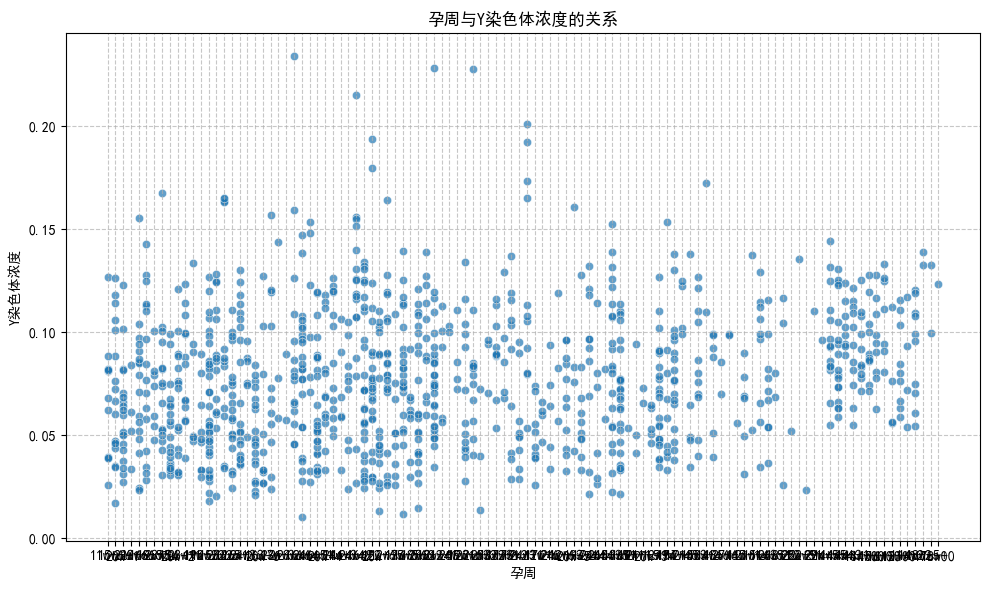

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

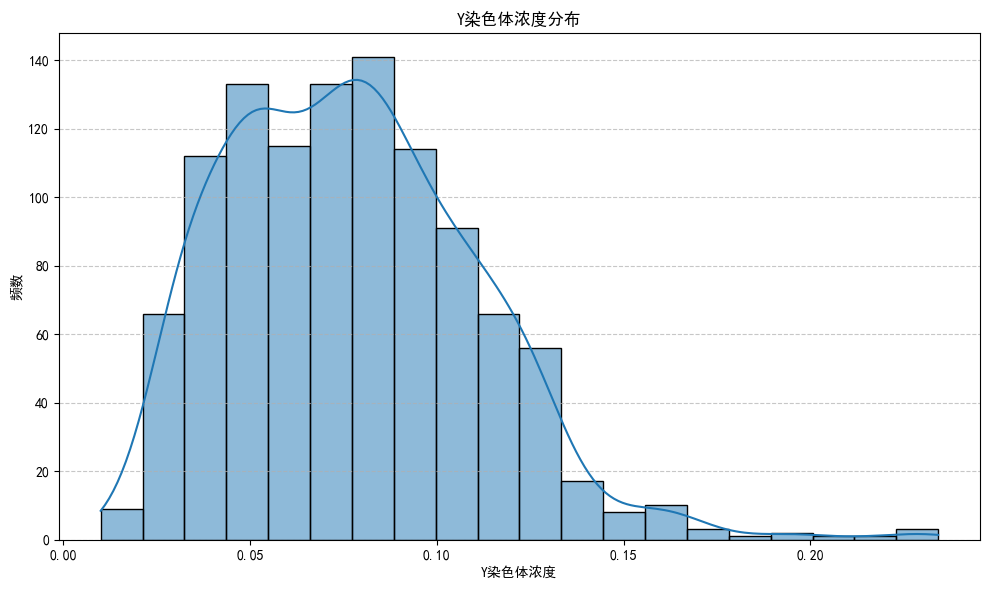

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

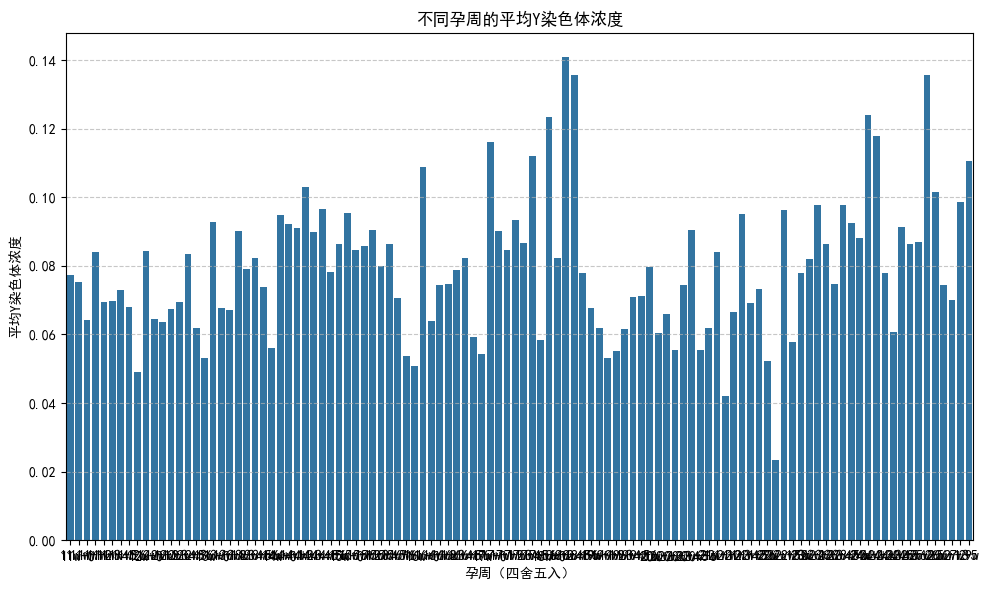

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 读取数据
df = pd.read_excel("nipt_data.xlsx")   # 替换为你的数据文件名

# 查看数据基本信息
print("数据基本信息：")
print(f"数据集形状：{df.shape}")
print("\n列名列表：")
print(df.columns.tolist())
print("\n前5行数据：")
print(df.head())

# 数据清洗 - 处理缺失值
print("\n缺失值统计：")
print(df.isnull().sum())

# 筛选男胎数据（使用Y染色体浓度不为空作为判断依据）
df_male = df[df["Y染色体浓度"].notna()].copy()
print(f"\n筛选出男胎样本数：{len(df_male)}")

# 提取关键变量
df_male["孕周"] = df_male["检测孕周"]   # 孕妇孕周
df_male["Y浓度"] = df_male["Y染色体浓度"]  # Y染色体浓度

# 基本统计描述
print("\nY染色体浓度统计描述：")
print(df_male["Y浓度"].describe())

# 绘制孕周与Y染色体浓度的散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_male, x="孕周", y="Y浓度", alpha=0.7)
plt.title("孕周与Y染色体浓度的关系")
plt.xlabel("孕周")
plt.ylabel("Y染色体浓度")
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 绘制Y染色体浓度的直方图
plt.figure(figsize=(10, 6))
sns.histplot(df_male["Y浓度"], kde=True, bins=20)
plt.title("Y染色体浓度分布")
plt.xlabel("Y染色体浓度")
plt.ylabel("频数")
plt.grid(linestyle="--", alpha=0.7, axis="y")
plt.tight_layout()
plt.show()

# 按孕周分组统计Y染色体浓度的平均值
week_group = df_male.groupby(df_male["孕周"].round())["Y浓度"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=week_group, x="孕周", y="Y浓度")
plt.title("不同孕周的平均Y染色体浓度")
plt.xlabel("孕周（四舍五入）")
plt.ylabel("平均Y染色体浓度")
plt.grid(linestyle="--", alpha=0.7, axis="y")
plt.tight_layout()
plt.show()